## A. Libraries

In [ ]:
pip install py_vollib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 5.6 MB/s eta 0:00:00
  Created wheel for py_vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62855 sha256=e3f69cf00d8215abf3036fb4a398cee9549454075fb7884f6d13045047b802ec
  Stored in directory: /root/.cache/pip/wheels/38/8d/d9/a680031767bd6a3d734fc7c48a75767591795e47ac66ca143c
  Created wheel for py_lets_be_rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24470 sha256=84c9960ee12f3c466ac958e54021ff6b90cb2cac511c3e5bbfbcea529b85a278
  Stored in directory: /root/.cache/pip/wheels/e6/67/1e/93e41aebf34e4fd3cb02a865e9c782c9edaac5051f15a01d2e
Successfully built py_vollib py_lets_be_rational


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import py_vollib.black_scholes.implied_volatility as ivol
import py_vollib.black_scholes as bs

## B. Helper Functions

### 1. Euler Simulation

In [ ]:
def Euler_scheme(St = 100, vt = 0.05, T = 1, dt = 1/365, 
                 price_drift = 0, kappa = 0.1, theta = 0.04, eta = 0.5, rho = 0,
                 get_processes= False, get_VS = False):
    """
    This function is to simulate the asset price St at any given time T (year) under the assumption that:
    (1) The price is determined by drift term (change in time) and random term (Brownian motion)
    (2) The volatility of the return offered by the asset is time-variant
    (3) The random factors affecting asset price and the random factors affecting its return volatility correlate with eachother
        via the coefficient `rho
    (4) The (change in) time is measured in years
    
    Arguments:
        Group (1) - Instrument's characteristics
        - St [float] the known price of asset at time t < T (eg., S_0)
        - vt [float] the known return volatility asset at time t < T (eg., v_0)
        - T [float] - the number of years, from initial time t up till which we want to simulate the price evolution
        - dt [float] - the time length of a subinterval, measured in year(s) | by default, dt = 1 day
        Group (2) - Constants
        - price_drift [float] the coefficent of dt (sometime denoted as mu, or r)
        - kappa, theta, eta [positive float] - constants determining the weights of drift factor and random factor
        - rho [float in [-1, 1] interval] - the correlation coefficient between the 2 Brownian motions
        Group (3) - What to return
        - get_processes [bool] whether to return all the processes including Brownian motions, Variance, and Price
    Return:
        - Ws [array] of shape (T*N+1,) - the random factor determining the asset price
        - Wv [array] of shape (T*N+1,) - the random factor determining the asset return volatility
        - V [array] of shape(T*N+1,) - the variance of the returns offered by the asset
        - S [array] of shape (T*N+1,) - the asset price series at the discrete time points over the interval [0, T*N]
    """
    
    #---------------(1) Simulate Brownian motions---------------
    #The subinterval between time t and time (t+1), measured in year(s)
    N = int(T*365)
    
    #The increments dX1 and dX2
    dX_std = np.sqrt(dt)
    dX1t = np.random.normal(loc = 0,
                            scale = dX_std,
                            size = N)
    dX1t = np.hstack([0, dX1t])
    
    dX2t = np.random.normal(loc = 0,
                            scale = dX_std,
                            size = N)
    dX2t = np.hstack([0, dX2t])
    
    #Lower triangular matrix
    TriL = np.tril(m = np.ones((N+1, N+1)),
                  k = 0)
    
    #Ws
    Ws = np.dot(TriL, dX1t) #Also X1
    
    X2 = np.dot(TriL, dX2t)
    Wv = Ws*rho + np.sqrt(1-rho**2)*X2
    
    #---------------(2) Price Simulation by Euler scheme---------------
    dT = np.arange(N+1)/N # --> A series of time increments (in years) from t(=0) to any points in the interval [0, T*N]
    
    V = np.array([vt])
    for i in range(1, N+1):
        dvi = kappa*(theta - vt)*dT[i] + eta*(vt**(1/2))*(Wv[i])
        V = np.append(V, np.abs(vt + dvi))
    
    
    sqrtV = np.sqrt(V)
    
    S = np.array([St])
    for i in range(1, N+1):
        dSi = (price_drift-1/2*V[i])*dT[i] + sqrtV[i]*Ws[i]
        lnSi = np.log(St) + dSi 
        S = np.append(S, np.exp(lnSi))
    
    if get_processes:
        return Ws, Wv, V, S
    if get_VS:
        return V, S
    return S

In [ ]:
def Price_simulation_byEuler(n_paths = 1,
                             #Parameters for Euler_scheme function
                             St = 100, vt = 0.05, T = 1, dt = 1/365,
                             price_drift = 0, kappa = 0.1, theta = 0.04, eta = 0.5, rho = 0,
                             get_processes= False, get_VS = True):
    N = int(T*365)
    V = np.array([])
    Ss = np.array([])
    for i in range(n_paths):
        Vi, Ssi = Euler_scheme(St = St, vt = vt, T = T, dt = dt,
                               price_drift = price_drift, kappa = kappa, theta = theta, eta = eta, rho = rho,
                               get_processes= get_processes, get_VS = get_VS)
        Ss = np.append(Ss, Ssi)
        Ss = Ss.reshape(i+1, N+1)
    
        V = np.append(V, Vi)
        V = V.reshape(i+1, N+1)
    if get_VS:
        return V, Ss
    else:
        return Ss

In [ ]:
#Price estimation
def price_estimate(ST, K, r, T):
    SmK_zeros = np.hstack(( (ST - K).reshape(ST.shape[0], -1),
                             np.full((ST.shape[0], 1), 0) )).reshape(ST.shape[0], -1)
    VT = np.apply_along_axis(np.max, 1, SmK_zeros)
    return VT.mean() * np.exp(-r*T)

### 2. QE Simulation

In [ ]:
def QE_scheme(St = 100, vt = 0.05, T = 1, dt = 1/365, r = 0.02,
                 price_drift = 0, kappa = 0.1, theta = 0.04, eta = 0.5, rho = 0, 
                 get_VS = False):
  N = T*365
  e = np.exp(-kappa*dt)
  
  V = np.array([vt])
  for i in range(1, N+1):
    Vt = V[-1]
    m = theta + (Vt - theta)*e
    s_sqr = (Vt * eta**2 * e)/(kappa) * (1 - e) + (theta * eta**2)/(2*kappa) * (1 - e)**2
    psi = s_sqr/m**2
    u = np.random.random()
    if psi <= 1.5:
      b_sqr = 2*(1/psi) - 1 + np.sqrt(2*(1/psi))*np.sqrt(2*(1/psi) - 1)
      a = m/(1 + b_sqr)
      Zv = np.random.normal()
      newV = a*(np.sqrt(b_sqr) + Zv)**2
    
    else:
      p = (psi - 1)/(psi + 1)
      beta = (1 - p)/m
      if 0 <= u <= p:
        newV = 0
      else:
        newV = (1/beta)*np.log((1 - p)/(1 - u))
    V = np.append(V, newV)
    
  gamma1 = 1/2
  gamma2 = 1/2
  K0 = -(rho*kappa*theta)/(eta) * dt
  K1 = gamma1 * dt * ((kappa*rho)/(eta) - (1/2)) - (rho/eta)
  K2 = gamma2 * dt * ((kappa*rho)/(eta) - (1/2)) + (rho/eta)
  K3 = gamma1 * dt * (1 - rho**2)
  K4 = gamma2 * dt * (1 - rho**2)

  S = np.array([St])
  for i in range(1, N+1):
    Z = np.random.normal()
    lnSi = np.log(S[-1]) + r*dt + K0 + K1*V[i-1] + K2*V[i] + np.sqrt(K3*V[i-1] + K4*V[i])*Z
    S = np.append(S, np.exp(lnSi))

  if get_VS:
      return V, S
  return S

In [ ]:
def Price_simulation_byQE(n_paths = 1,
                             #Parameters for QE_scheme function
                             St = 100, vt = 0.05, T = 1, dt = 1/365, r = 0.02,
                             price_drift = 0, kappa = 0.1, theta = 0.04, eta = 0.5, rho = 0,
                             get_VS = True):
    N = T*365
    V = np.array([])
    Ss = np.array([])
    for i in range(n_paths):
        Vi, Ssi = QE_scheme(St = St, vt = vt, T = T, dt = dt, r = r,
                               price_drift = price_drift, kappa = kappa, theta = theta, eta = eta, rho = rho,
                               get_VS = get_VS)
        Ss = np.append(Ss, Ssi)
        Ss = Ss.reshape(i+1, N+1)
    
        V = np.append(V, Vi)
        V = V.reshape(i+1, N+1)
    if get_VS:
        return V, Ss
    else:
        return Ss

## C. Assignment Questions

We use Heston model to generate implied volatility observed in the market

We assume that, under risk-neutral measure,

$(1) \ \ \frac{dS}{S} = rdt + \sqrt{v_{t}}dW$

$(2) \ \ dv_{t} = \kappa(\theta - v_{t})dt + \eta\sqrt{v_{t}}dW^{v}$

For this exercise, we use the following values to simulate correlated Wiener processes

|$r$       |$\kappa$  |$\theta$  |$\eta$    |$\rho$    |
|----------|----------|----------|----------|----------|
|2%        |0.1       |0.04      |0.5       |-0.6      |

In [ ]:
r = 0.02
kappa = 0.1
theta = 0.04
eta = 0.5
rho = -0.6

### a. Simulate daily stock price to price options

Simulate daily stock price movement and use the simulation to price 1-year European call options with 
- $S_0$ = 100
- $K$ = $[75, 125]$ with $5 increments
- The instantaneous variance should be equal to its long run mean

In [ ]:
T = 1
N = T*365

#### a1. Simulation by Euler Method

In [ ]:
V_Euler, S_Euler = Price_simulation_byEuler(1000,
                                           St = 100, vt = r, T = 1, dt = 1/365,
                                           price_drift = r, kappa = 0.1, theta = 0.04, eta = 0.5, rho = 0,
                                           get_processes= False, get_VS = True)

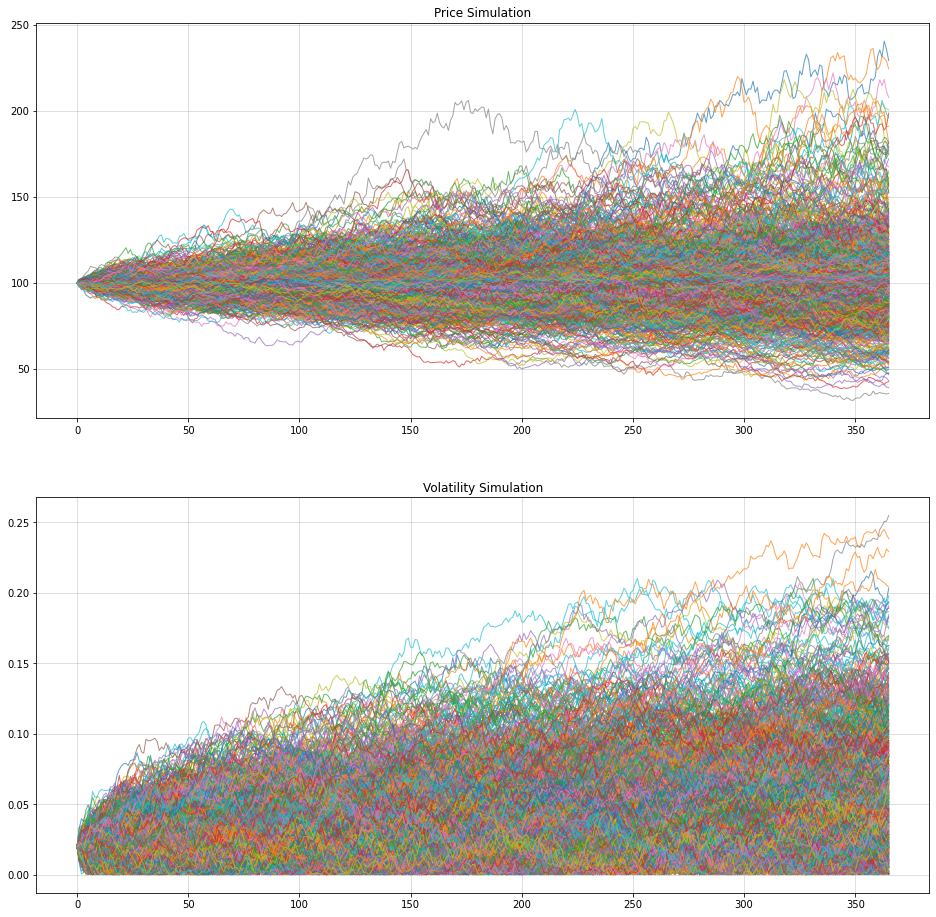

In [ ]:
fig = plt.figure(figsize = (16, 16))

X = np.arange(N+1)

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title('Price Simulation')
ax1.plot(X, S_Euler.T, lw = 1, alpha = 0.7)
ax1.grid (True, alpha = 0.5)

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title('Volatility Simulation')
ax2.plot(X, V_Euler.T, lw = 1, alpha = 0.7)
ax2.grid (True, alpha = 0.5)

plt.show()

#### Estimate the Price European Option Using Simulated Price

In [ ]:
C_Euler = np.array([])
for K in np.arange(75, 125+5, 5):
    C_Euler = np.append(C_Euler, 
                    price_estimate(S_Euler[:, -1], K, r, T))

In [ ]:
C_Euler_df = pd.DataFrame({'Strike Price': np.arange(75,130,5),
                            'European Call': C_Euler})
C_Euler_df

,Strike Price,European Call
0,75,26.798592
1,80,22.539724
2,85,18.586889
3,90,14.988990
4,95,11.803441
5,100,9.099630
6,105,6.931332
7,110,5.308888
8,115,4.081360
9,120,3.183415


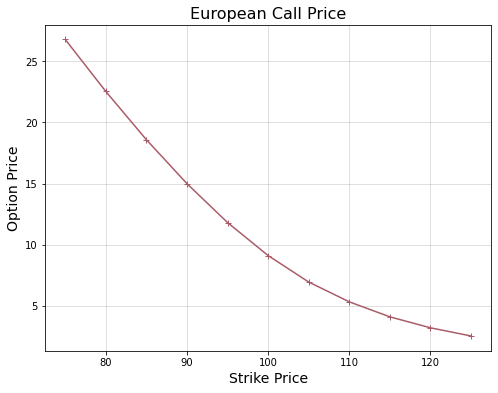

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(np.arange(75, 125+5, 5), C_Euler, marker = '+', label = 'European Call Price', color = '#A95C68')

ax.set_title('European Call Price', size = 16)
ax.set_xlabel('Strike Price', size = 14)
ax.set_ylabel('Option Price', size = 14)

ax.grid(True, alpha = 0.5)

plt.show()

#### a2. Simulation by QE Method

In [ ]:
V_QE, S_QE = Price_simulation_byQE(1000,
                                   St = 100, vt = r, T = 1, dt = 1/365, r = 0.02,
                                   price_drift = 0, kappa = 0.1, theta = 0.04, eta = 0.5, rho = 0,
                                   get_VS = True)

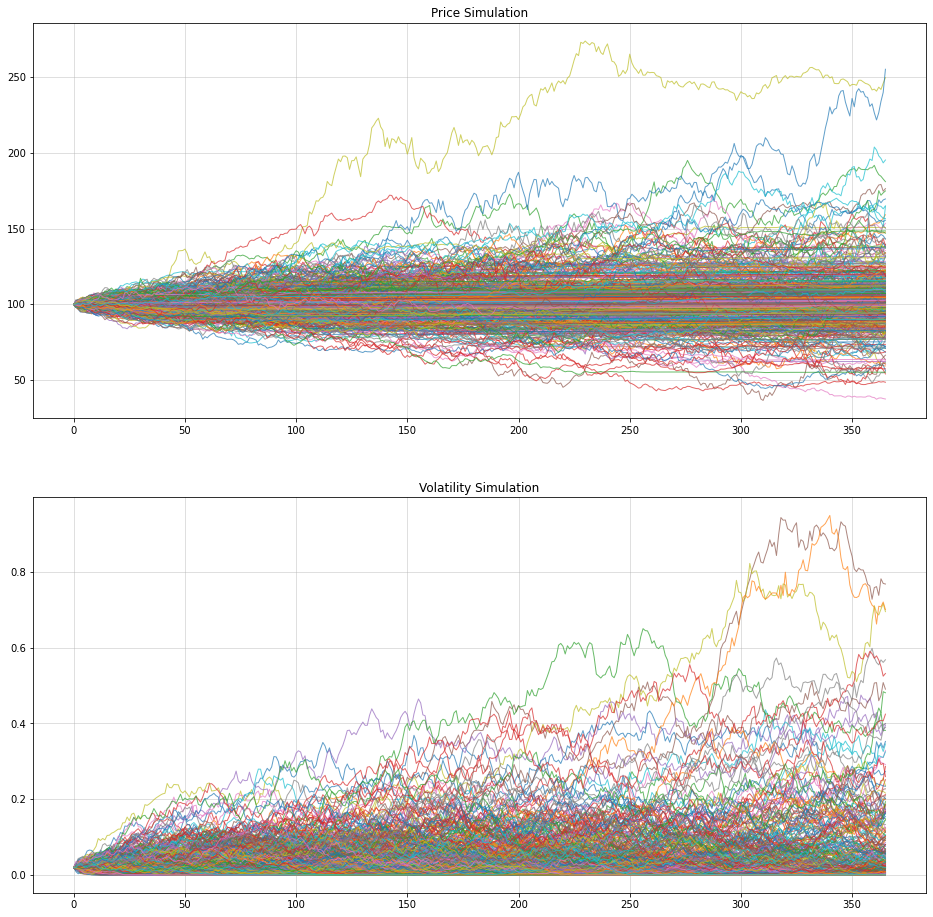

In [ ]:
fig = plt.figure(figsize = (16, 16))

X = np.arange(N+1)

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title('Price Simulation')
ax1.plot(X, S_QE.T, lw = 1, alpha = 0.7)
ax1.grid (True, alpha = 0.5)

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title('Volatility Simulation')
ax2.plot(X, V_QE.T, lw = 1, alpha = 0.7)
ax2.grid (True, alpha = 0.5)

plt.show()

#### Estimate the Price European Option Using Simulated Price

In [ ]:
C_QE = np.array([])
for K in np.arange(75, 125+5, 5):
    C_QE = np.append(C_QE, 
                    price_estimate(S_QE[:, -1], K, r, T))

In [ ]:
C_QE_df = pd.DataFrame({'Strike Price': np.arange(75,130,5),
                            'European Call': C_QE})
C_QE_df

,Strike Price,European Call
0,75,27.168815
1,80,22.418925
2,85,17.779188
3,90,13.295269
4,95,9.111963
5,100,5.542678
6,105,3.332029
7,110,2.318728
8,115,1.745891
9,120,1.340889


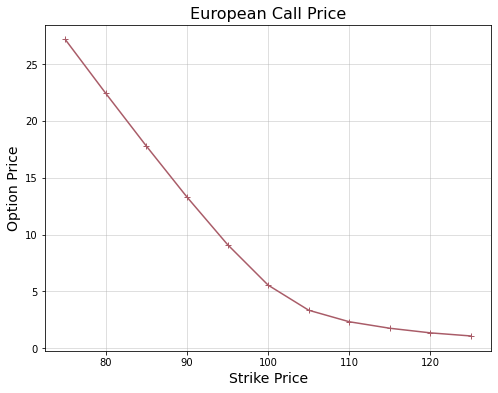

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(np.arange(75, 125+5, 5), C_QE, marker = '+', label = 'European Call Price', color = '#A95C68')

ax.set_title('European Call Price', size = 16)
ax.set_xlabel('Strike Price', size = 14)
ax.set_ylabel('Option Price', size = 14)

ax.grid(True, alpha = 0.5)

plt.show()

### b. Compute the implied volatility of each option and plot against strike prices

By Euler

In [ ]:
vols_Euler = np.array([])
K = np.arange(75, 125+5, 5)
for i in range(len(C_Euler)):
  vol = ivol.implied_volatility(C_Euler[i], 100, K[i], 1, 0.02, 'c')
  vols_Euler = np.append(vols_Euler, vol)

By QE

In [ ]:
vols_QE = np.array([])
K = np.arange(75, 125+5, 5)
for i in range(len(C_QE)):
  try:
    vol = ivol.implied_volatility(C_QE[i], 100, K[i], 1, 0.02, 'c')
  except:
    vol = 0
  vols_QE = np.append(vols_QE, vol)

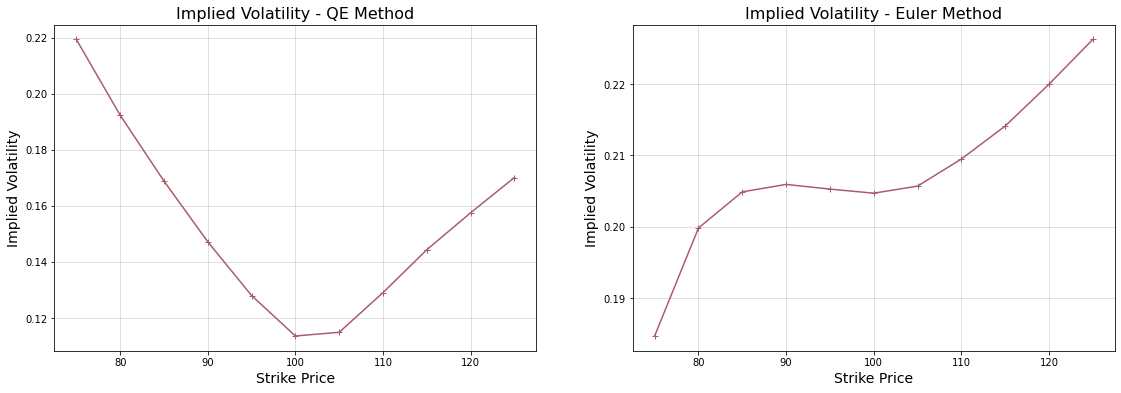

In [ ]:
fig = plt.figure(figsize = (19,6))

ax = fig.add_subplot(1, 2, 1)
ax.plot(K, vols_QE, marker = '+', label = 'Implied Volatility - QE Method', color = '#A95C68')

ax.set_title('Implied Volatility - QE Method', size = 16)
ax.set_xlabel('Strike Price', size = 14)
ax.set_ylabel('Implied Volatility', size = 14)

ax.grid(True, alpha = 0.5)

ax2 = fig.add_subplot(1, 2, 2)

ax2.plot(K, vols_Euler, marker = '+', label = 'Implied Volatility - Euler Method', color = '#A95C68')

ax2.set_title('Implied Volatility - Euler Method', size = 16)
ax2.set_xlabel('Strike Price', size = 14)
ax2.set_ylabel('Implied Volatility', size = 14)
ax2.grid(True, alpha = 0.5)


plt.show()

### c. Heston vs Black-Scholes

Compare the option prices under the Heston model with those under the Black-Scholes model assuming the variance is constant and equal to the long run mean.

In [ ]:
C_BS = np.array([])
K = np.arange(75, 125+5, 5)
for i in range(len(K)):
    C_BS = np.append(C_BS, bs.black_scholes('c', 100, K[i], 0.04, 1, 0.02))

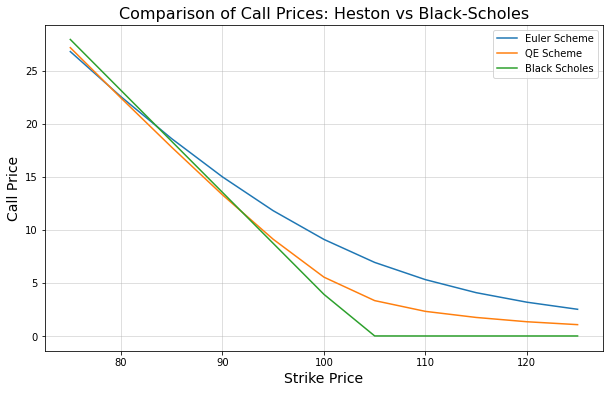

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(K, C_Euler, label = 'Euler Scheme')
ax.plot(K, C_QE, label = 'QE Scheme')
ax.plot(K, C_BS, label = 'Black Scholes')
ax.legend()

ax.set_title('Comparison of Call Prices: Heston vs Black-Scholes', size = 16)
ax.set_xlabel('Strike Price', size = 14)
ax.set_ylabel('Call Price', size = 14)

ax.grid(True, alpha = 0.5)

plt.show()

__Comments on the convergence__

- As can be seen in the graph, the price plot derived from Black-Scholes formula and that from QE simulation method are very close to each other for the strike price up to 100. The price plot given by Euler simulation method does not seem to converge very strongly to the other 2, but does share the similar pattern of downward sloping. It appears that for the strike prices close to 75 or 125, the 3 plots converge pretty well
- While BS plot shows kind of a 'kink', the other 2 plots appear to be much smoother


## D. Test the Pricing Precision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Numerical Analysis/dataD1.xlsx'

In [ ]:
data = pd.read_excel(data_dir)
data

,Spot,Maturity,Strike,Interest rate,Mid,Bid,Ask
0,328.29,0.175342,275,0.000554,56.90,55.5,58.3
1,328.29,0.175342,300,0.000554,36.30,35.0,37.6
2,328.29,0.175342,325,0.000554,19.60,19.3,19.9
3,328.29,0.175342,350,0.000554,9.45,9.2,9.7
4,328.29,0.175342,375,0.000554,4.30,4.1,4.5
5,328.29,0.424658,275,0.000659,63.20,61.7,64.7
6,328.29,0.424658,300,0.000659,44.90,44.4,45.4
7,328.29,0.424658,325,0.000659,30.55,30.2,30.9
8,328.29,0.424658,350,0.000659,20.05,19.7,20.4
9,328.29,0.424658,375,0.000659,12.50,12.2,12.8


Given that the optimal set of parameters are

|$r$       |$\kappa$  |$\theta$  |$\eta$    |$\rho$    |
|----------|----------|----------|----------|----------|
|2%        |0.1       |0.04      |0.5       |-0.6      |

In [ ]:
V_Euler_test, S_Euler_test = Price_simulation_byEuler(1000,
                                           St = data.loc[0, 'Spot'], vt = r, T = data.loc[0, 'Maturity'], dt = 1/365,
                                           price_drift = data.loc[0, 'Interest rate'], kappa = 0.1, theta = 0.04, eta = 0.5, rho = 0,
                                           get_processes= False, get_VS = True)

In [ ]:
CE_test = np.array([])

for i in data.index:
  #Simulate
  V_Euler_test, S_Euler_test = Price_simulation_byEuler(1000,
                                                        St = data.loc[i, 'Spot'], vt = r, T = data.loc[i, 'Maturity'], dt = 1/365,
                                                        price_drift = data.loc[i, 'Interest rate'], kappa = 0.1, theta = 0.04, eta = 0.5, rho = 0,
                                                        get_processes= False, get_VS = True)
  
  #Price
  C_Euler_test = np.array([])
  
  C_Euler_test = np.append(C_Euler_test,
                             price_estimate(S_Euler_test[:, -1], #spot,
                                            data.loc[i, 'Strike'], #Strike,
                                            data.loc[i, 'Interest rate'],#interest rate,
                                            data.loc[i, 'Maturity'] #maturity
                                            ))
  CE_test = np.append(CE_test,
                      C_Euler_test)
  

In [ ]:
CE_test

array([49.94887661, 26.49382151,  7.92191363,  1.67850353,  0.46096937,
       53.24911822, 31.97175654, 15.71804404,  6.81853704,  3.00463811,
       61.58687751, 44.48224569, 30.07620316, 21.70128037, 11.57784817])

In [ ]:
CBS_test = np.array([])
for i in data.index:
    CBS_test = np.append(CBS_test, bs.black_scholes('c', data.loc[i, 'Spot'], data.loc[i, 'Strike'], data.loc[i, 'Maturity'], data.loc[i, 'Interest rate'], 0.02))

In [ ]:
CBS_test

array([5.33167014e+01, 2.83191288e+01, 3.47057945e+00, 4.07550229e-15,
       8.97401038e-58, 5.33670023e+01, 2.83740025e+01, 3.89782627e+00,
       4.19489537e-07, 5.07320545e-25, 5.35058196e+01, 2.85254408e+01,
       4.66499649e+00, 8.56531191e-04, 2.79133570e-12])

Error

In [ ]:
Error_BS = ((CBS_test - data['Mid'])**2).mean()
Error_BS

536.6895801629452

In [ ]:
Error_E = ((CE_test - data['Mid'])**2).mean()
Error_E

173.74371004698065

In [ ]:
(1 - Error_E/Error_BS)*100

67.62677784908176